In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"  # add this
## TODO: Add comments about this flag 
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"


import jax

jax.devices()

[gpu(id=0)]

In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)
    
    
data_dir = './data/tfds'

1 Physical GPUs, 1 Logical GPUs


In [4]:
data, info = tfds.load('mnist', data_dir=data_dir, as_supervised=True, with_info=True)

In [5]:
data_train = data['train']
data_test = data['test']

In [6]:
info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='./data/tfds/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

## Visualize data

2023-06-26 00:19:57.924812: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


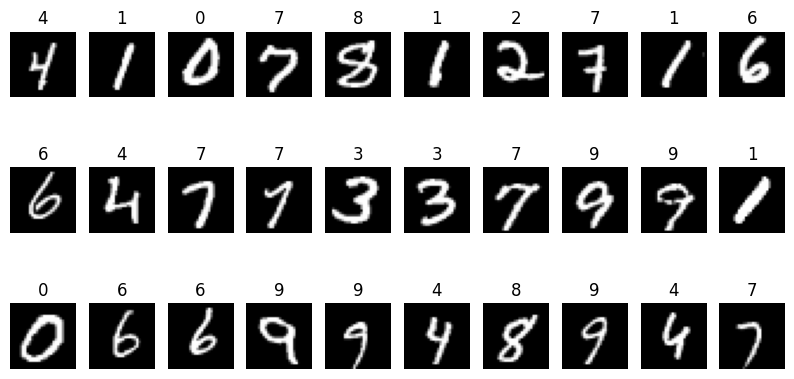

In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

ROWS = 3
COLS = 10

i = 0
fig, ax = plt.subplots(ROWS, COLS)
for image, label in data_train.take(ROWS*COLS):
    ax[int(i/COLS), i%COLS].axis('off')
    ax[int(i/COLS), i%COLS].set_title(str(label.numpy()))
    ax[int(i/COLS), i%COLS].imshow(np.reshape(image, (28,28)), cmap='gray')
    i += 1

plt.show()


## Batch and preprocess (normalize) training and test data 

In [8]:


HEIGHT = 28
WIDTH = 28
CHANNELS = 1
BATCH_SIZE = 32
PREFETCH = 1

NUM_PIXELS = HEIGHT * WIDTH * CHANNELS
NUM_LABELS = info.features['label'].num_classes

In [9]:
def preprocess(img, label):
    return tf.cast(img, tf.float32) / 255.0, label


train_data = tfds.as_numpy(data_train.map(preprocess).batch(BATCH_SIZE).prefetch(PREFETCH))
test_data = tfds.as_numpy(data_test.map(preprocess).batch(BATCH_SIZE).prefetch(PREFETCH))



In [11]:
from jax import random as jrand
import itertools

LAYER_DIMS = [28 * 28, 512, 10]
PARAM_SCALE = 0.01

def init_network_params(network_dims, key=jrand.PRNGKey(0), scale=1e-2):

    def generate_random_layer_params(input_dim, output_dim, rand_key):
        w_key, b_key = jrand.split(rand_key)
        return scale * jrand.normal(w_key, (output_dim, input_dim)), scale * jrand.normal(b_key, (output_dim,))
    
    rand_keys = jrand.split(key, len(network_dims))
    return list(itertools.starmap(generate_random_layer_params, zip(network_dims[:-1], network_dims[1:], rand_keys)))


        


### Forward pass of the model

In [12]:
import jax.numpy as jnp

from jax.nn import swish

def forward_pass(params, input_vec):
    """Get logits from forward pass of the neural network"""
    curr_activation = input_vec
    for w, b in params[:-1]:
        # print("Weight ", w.shape, "Bias ", b.shape)        
        curr_activation = swish(jnp.matmul(w, curr_activation) + b)

    final_w, final_b = params[-1]
    logits = jnp.matmul(final_w, curr_activation) + final_b
    return logits



In [13]:
random_flattened_images = jrand.normal(jrand.PRNGKey(1), (32, 28*28*1))
random_flattened_images.shape

(32, 784)

## Use vmap for batched forward pass

In [14]:
# Use first argument as is and batch the 2nd argument on 0th axis
batched_forward_pass = jax.vmap(forward_pass, in_axes=(None, 0))


### Loss function 

In [15]:
from jax.nn import logsumexp

def loss_fn(params, input_vecs, targets):
    """Takes a batch of inputs and computes cross entropy loss"""
    logits = batched_forward_pass(params, input_vecs)
    log_probs = logits - logsumexp(logits) # Uses the logsumexp trick to compute softmax - https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
    # cross entropy of dist P, Q = - \sigma_i P_i * log(Q_i)
    # So cross entropy here is just the dot product
    # print('logits shape ', logits.shape)
    return -jnp.mean(log_probs * targets)



## Gradient descent training

In [17]:
params = init_network_params(LAYER_DIMS, jrand.PRNGKey(42), scale=PARAM_SCALE)
for p in params:
    print(p[0].shape + ' ' + p[1].shape)

TypeError: can only concatenate tuple (not "str") to tuple

In [23]:
from jax import jit

INIT_LR = 1.0 
DECAY_RATE = .95
DECAY_UPDATE_FREQ = 5

# @jit
def update(params, input_vecs, targets, epoch_num):
    """Calculates the gradients wrt to params and updates based on learning rate"""

    loss, grads = jax.value_and_grad(loss_fn)(params, input_vecs, targets)
    lr = INIT_LR * DECAY_RATE ** (epoch_num / DECAY_UPDATE_FREQ)
    # print('loss shape', loss)
    # print('grads shape ', grads)
    
    return [(w - lr * dw, b - lr * db) for (w, b), (dw, db) in zip(params, grads)], loss
    

In [19]:
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from IPython import display
from IPython.display import clear_output

import time
import numpy as np


## Prediction report 

In [24]:

# @jit
def predict_class(params, img_batch, targets_batch):
    """Returns the argmax of the logits for a batch of inputs"""
    
    img_vec_batch = jnp.reshape(img_batch, (len(img_batch), NUM_PIXELS))
    pred_class = jnp.argmax(batched_forward_pass(params, img_vec_batch), axis=1)
    return pred_class

def predict_print_report(params, data):
    preds = []
    gts = []
    # TODO: change to map or vmap? 
    for img_batch, targets_batch in data:
        preds.append(predict_class(params, img_batch, targets_batch))
        gts.append(targets_batch)
        
    print(classification_report(np.concatenate(gts), np.concatenate(preds)))


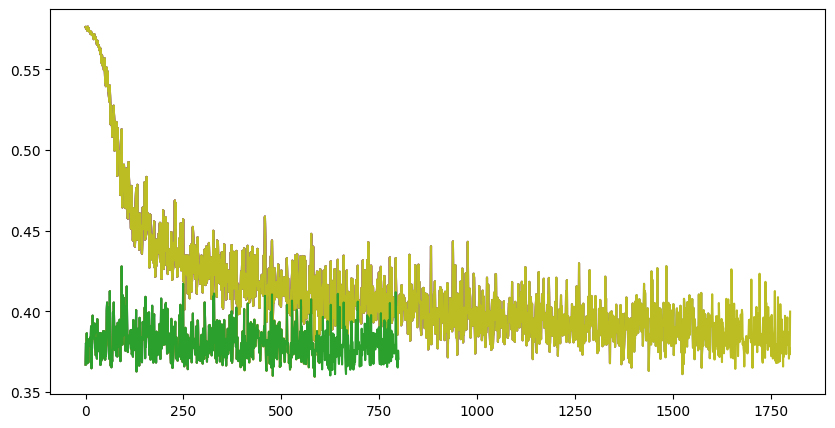

  0%|          | 0/5 [00:00<?, ?it/s]

Completed epoch 0 in 29.39s
Classification report for train data
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      5923
           1       0.94      0.97      0.96      6742
           2       0.95      0.90      0.93      5958
           3       0.92      0.89      0.91      6131
           4       0.90      0.95      0.92      5842
           5       0.90      0.89      0.90      5421
           6       0.94      0.96      0.95      5918
           7       0.95      0.94      0.94      6265
           8       0.91      0.89      0.90      5851
           9       0.91      0.89      0.90      5949

    accuracy                           0.93     60000
   macro avg       0.93      0.93      0.93     60000
weighted avg       0.93      0.93      0.93     60000

Classification report for test data
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.96      0.

In [25]:
from jax.nn import one_hot
import time

NUM_EPOCHS = 5

params = init_network_params(LAYER_DIMS, jrand.PRNGKey(42), scale=PARAM_SCALE)

xx = list()

# display the initial figure and get a display handle
# (it starts out blank here)
fig, ax = plt.subplots()
dh = display.display(fig, display_id=True)

    
    
PLOT_EVERY = 200

with tqdm(range(NUM_EPOCHS)) as t:
    for ep in t:
        start_time = time.time()
        losses = []

        # Training loop

        for input_img_batch, target_batch in train_data:
            # print("input shape", input_img_batch.shape, 'target shape ', target_batch.shape)
            x = jnp.reshape(input_img_batch, (len(input_img_batch), NUM_PIXELS))
            y = one_hot(target_batch, NUM_LABELS)
            # print('x shape', x.shape, 'y shapoe ', y.shape)
            # update params
            params, loss = update(params, x, y, ep)
            t.set_postfix(batch_loss=loss)
            losses.append(loss)
            if len(losses) % PLOT_EVERY == 0:
                ax.plot(*zip(*enumerate(losses)))
                dh.update(fig)

        ep_time_elapsed = time.time() - start_time
        print('Completed epoch {} in {:0.2f}s'.format(ep, ep_time_elapsed))
        start_time = time.time()
        # Accuracy on train set
        print('Classification report for train data')
        predict_print_report(params, train_data)
        # Accuracy on test data
        print('Classification report for test data')
        predict_print_report(params, test_data)
        
        print('Evaluated in {:0.2f}s'.format(time.time() - start_time))
        t.set_postfix(epoch_avg_loss=jnp.mean(jnp.array(losses)))
        
    


    
    
    


In [68]:
# Update plot
# https://stackoverflow.com/questions/66914972/how-do-i-dynamically-update-matplotlib-plots-in-a-tqdm-loop-inside-a-jupyter-not

# Clear output but not tqdm
# https://stackoverflow.com/questions/42782902/clear-widget-area-of-a-cell-in-a-jupyter-notebook-from-within-notebook

# tqdm update inner loop
# https://stackoverflow.com/questions/49244908/how-to-help-tqdm-figure-out-the-total-in-a-custom-iterator
